In [24]:
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer
from sys import getsizeof
import time

In [2]:
df = pd.read_table('../datasets/CheckThat_Lab/train_ml.tsv')
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_table('../datasets/CheckThat_Lab/test_ml.tsv')
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

In [3]:
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(5965, 3)
(663, 3)
(600, 2)


In [4]:
df.head()

,sentence_id,sentence,label
0,50f8b1cc-b96e-4845-a9fd-44b62a7e7863,"""Dat blijft bestaan, tot het wordt rechtgezet.""",OBJ
1,e59ab113-c755-4b55-9753-0a4e2a607500,"""Een samenleving waarin veel culturen samenlev...",OBJ
2,cd26b610-d10a-4059-adbe-d5382c7af8e7,Sul fronte opposto pare offuscata la posizione...,SUBJ
3,FAT_489-curl_03_007,كما يتم تنظيم المسيرات والمظاهرات أمام السفارا...,OBJ
4,8c880770-a393-4cc8-ba17-89cbf57432d0,"Denmark, Germany, and France have each seen 10...",OBJ


In [5]:
# Load the SBERT model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [6]:
# X_train = model.encode(list(df_train.sentence))
# X_dev = model.encode(list(df_dev.sentence))
# X_test = model.encode(list(df_test.sentence))

# y_train = df_train["label"]
# y_dev = df_dev["label"]

In [7]:
# # save the embedding results
# pickle.dump(X_train, open("./train_embeddings_originals.p","wb" ))
# pickle.dump(X_dev, open("./dev_embeddings_originals.p", "wb"))
# pickle.dump(X_test, open("./test_embeddings_originals.p", "wb"))

# # save the labels
# pickle.dump(y_train, open("./train_labels_originals.p", "wb"))
# pickle.dump(y_dev, open("./dev_labels_originals.p", "wb"))

In [6]:
# load the embeddings
X_train = pickle.load(open("./train_embeddings_originals.p", "rb"))
X_dev = pickle.load(open("./dev_embeddings_originals.p", "rb"))
X_test = pickle.load(open("./test_embeddings_originals.p", "rb"))

# load the labels
y_train = pickle.load(open("./train_labels_originals.p", "rb"))
y_dev = pickle.load(open("./dev_labels_originals.p", "rb"))

In [7]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [41]:
def svm_classification(baseline_results, X_train, y_train, X_dev, y_dev, kernels, suffix, verbose):
      
    for kernel in kernels:
        beg = time.time()  
        clf = SVC(kernel=kernel)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'SVM-{kernel} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'SVM-{kernel} {suffix}']['infer_time'] = end-beg
        if verbose:
            print(f"SVM with kernel: {kernel}", end='\t')
            print(clf.score(X_dev, y_dev))


In [42]:
def mlp_classification(baseline_results, X_train, y_train, X_dev, y_dev, layers, suffix, verbose):
    for layer in layers:
        beg = time.time()
        clf = MLPClassifier(hidden_layer_sizes=layer, max_iter=3000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'MLP-{layer} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'MLP-{layer} {suffix}']['infer_time'] = end-beg
        
        if verbose:
            print(f"MLP with layers: {layer}", end='\t')
            print(clf.score(X_dev, y_dev))

In [43]:
def random_forest_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_estimators, suffix, verbose):
    for n in n_estimators:
        beg = time.time()
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'RandomForest-{n} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'RandomForest-{n} {suffix}']['infer_time'] = end-beg
        
        if verbose:
            print(f"Random Forest with n_estimators: {n}", end='\t')
            print(clf.score(X_dev, y_dev))

In [44]:
def knn_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_neighbors, suffix, verbose):
    for n in n_neighbors:
        beg = time.time()
        clf = KNeighborsClassifier(n_neighbors=n)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'KNN-{n} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'KNN-{n} {suffix}']['infer_time'] = end-beg

        if verbose:
            print(f"KNN with n_neighbors: {n}", end='\t')
            print(clf.score(X_dev, y_dev))


In [45]:
def naive_bayes_classification(baseline_results, X_train, y_train, X_dev, y_dev, suffix, verbose):
    beg = time.time()
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)
    end = time.time()
    baseline_results[f'Naive-Bayes {suffix}'] = classification_report(y_dev, y_pred, output_dict=True, zero_division=0)
    baseline_results[f'Naive-Bayes {suffix}']['infer_time'] = end-beg
    
    if verbose:
        print(f'Naive Bayes\t{clf.score(X_dev, y_dev)}')

In [46]:
def run_classifiers(X_train, y_train, X_dev, y_dev, suffix='', verbose=False, results=None, **kwargs):
    if results is None:
        results = {}
    
    if verbose:
        print('Classifier\tAccuracy')
    
    svm_kernels = kwargs.get('svm_kernels', ['linear', 'poly', 'rbf', 'sigmoid'])
    svm_classification(results, X_train, y_train, X_dev, y_dev, svm_kernels, suffix, verbose)

    layers = kwargs.get('mlp_layers', [(100,), (100, 100), (200, 100), (100, 50), (200, 100, 50)])
    mlp_classification(results, X_train, y_train, X_dev, y_dev, layers, suffix, verbose)

    n_estimators = kwargs.get('rf_n_estimators', [10, 50, 100, 200, 500])
    random_forest_classification(results, X_train, y_train, X_dev, y_dev, n_estimators, suffix, verbose)

    n_neighbors = kwargs.get('knn_n_neighbors', [10, 20, 50, 100, 200, 500])
    knn_classification(results, X_train, y_train, X_dev, y_dev, n_neighbors, suffix, verbose)

    naive_bayes_classification(results, X_train, y_train, X_dev, y_dev, suffix, verbose)

    return results

In [218]:
# plot the best results for each classifier
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(baseline_results, metric, threshold=-1, figsize=(10, 5), title='Baseline Results'):
    plt.rcParams['figure.dpi'] = 300
    sorted_results = sorted([(k, v['macro avg'][metric]) for k, v in baseline_results.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("Classifier")
    sns.barplot(x=[x[1] for x in sorted_results if x[1] > threshold], y=[x[0] for x in sorted_results if x[1] > threshold]) 
    plt.xlim(0, min(max([x[1] for x in sorted_results])+0.07, 1))
    
    # put the scores on the bars
    for i, v in enumerate([x[1] for x in sorted_results]):
        if v > threshold:
            # set fonr size
            plt.text(v, i + .26, f'{v:.3f}', color='black', rotation=-90, fontsize=8)

def plot_sizes(sizes, title, xlabel, figsize=(10, 5), is_ratio=False):
    # set dpi
    plt.rcParams['figure.dpi'] = 300
    sorted_sizes = sorted([(k, v) for k, v in sizes.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Method")

    if is_ratio:
        sns.barplot(x=[x[1] for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, max([x[1] for x in sorted_sizes])+10)
        # for i, v in enumerate([x[1] for x in sorted_sizes]):
        #     plt.text(v, i + .25, f'{v:.2f}', color='black')
    else:
        sns.barplot(x=[x[1]/(1024*1024) for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, 10)
        for i, v in enumerate([x[1] for x in sorted_sizes]):
            plt.text(v/(1024*1024), i + .25, f'{v/(1024*1024):.2f} MB', color='black')


    plt.tight_layout()

def plot_inference_time(inference_times, title, xlabel, figsize=(10, 5)):
    plt.rcParams['figure.dpi'] = 300
    sorted_inference_times = sorted([(k, v['infer_time']) for k, v in inference_times.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Classifier")
    # vertical barplot

    sns.barplot(x=[x[1] for x in sorted_inference_times], y=[x[0] for x in sorted_inference_times])

    
    plt.xlim(0, 6)
    for i, v in enumerate([x[1] for x in sorted_inference_times]):
        plt.text(v, i + .25, f'{v:.2f} s', color='black')

    plt.tight_layout()

    


In [64]:
baseline_results['SVM-rbf ']

{'OBJ': {'precision': 0.7874015748031497,
  'recall': 0.9049773755656109,
  'f1-score': 0.8421052631578948,
  'support': 442},
 'SUBJ': {'precision': 0.7290322580645161,
  'recall': 0.5113122171945701,
  'f1-score': 0.601063829787234,
  'support': 221},
 'accuracy': 0.7737556561085973,
 'macro avg': {'precision': 0.7582169164338328,
  'recall': 0.7081447963800904,
  'f1-score': 0.7215845464725644,
  'support': 663},
 'weighted avg': {'precision': 0.7679451358902718,
  'recall': 0.7737556561085973,
  'f1-score': 0.7617581187010078,
  'support': 663},
 'infer_time': 5.337870836257935}

In [48]:
configurations = {
    'svm_kernels': ['rbf', 'linear'],
    'mlp_layers': [(100,), (200, 100)],
    'rf_n_estimators': [100, 200],
    'knn_n_neighbors': [20, 50, 100],
}

In [49]:
baseline_results = run_classifiers(X_train, y_train, X_dev, y_dev, verbose=True, **configurations)

Classifier	Accuracy
SVM with kernel: rbf	0.7737556561085973
SVM with kernel: linear	0.7541478129713424
MLP with layers: (100,)	0.7360482654600302
MLP with layers: (200, 100)	0.7571644042232277
Random Forest with n_estimators: 100	0.7330316742081447
Random Forest with n_estimators: 200	0.7300150829562594
KNN with n_neighbors: 20	0.7209653092006033
KNN with n_neighbors: 50	0.7164404223227753
KNN with n_neighbors: 100	0.7285067873303167
Naive Bayes	0.6772247360482655


In [50]:
baseline_results

{'SVM-rbf ': {'OBJ': {'precision': 0.7874015748031497,
   'recall': 0.9049773755656109,
   'f1-score': 0.8421052631578948,
   'support': 442},
  'SUBJ': {'precision': 0.7290322580645161,
   'recall': 0.5113122171945701,
   'f1-score': 0.601063829787234,
   'support': 221},
  'accuracy': 0.7737556561085973,
  'macro avg': {'precision': 0.7582169164338328,
   'recall': 0.7081447963800904,
   'f1-score': 0.7215845464725644,
   'support': 663},
  'weighted avg': {'precision': 0.7679451358902718,
   'recall': 0.7737556561085973,
   'f1-score': 0.7617581187010078,
   'support': 663},
  'infer_time': 5.337870836257935},
 'SVM-linear ': {'OBJ': {'precision': 0.7900207900207901,
   'recall': 0.8597285067873304,
   'f1-score': 0.8234019501625136,
   'support': 442},
  'SUBJ': {'precision': 0.6593406593406593,
   'recall': 0.5429864253393665,
   'f1-score': 0.5955334987593052,
   'support': 221},
  'accuracy': 0.7541478129713424,
  'macro avg': {'precision': 0.7246807246807248,
   'recall': 0.701

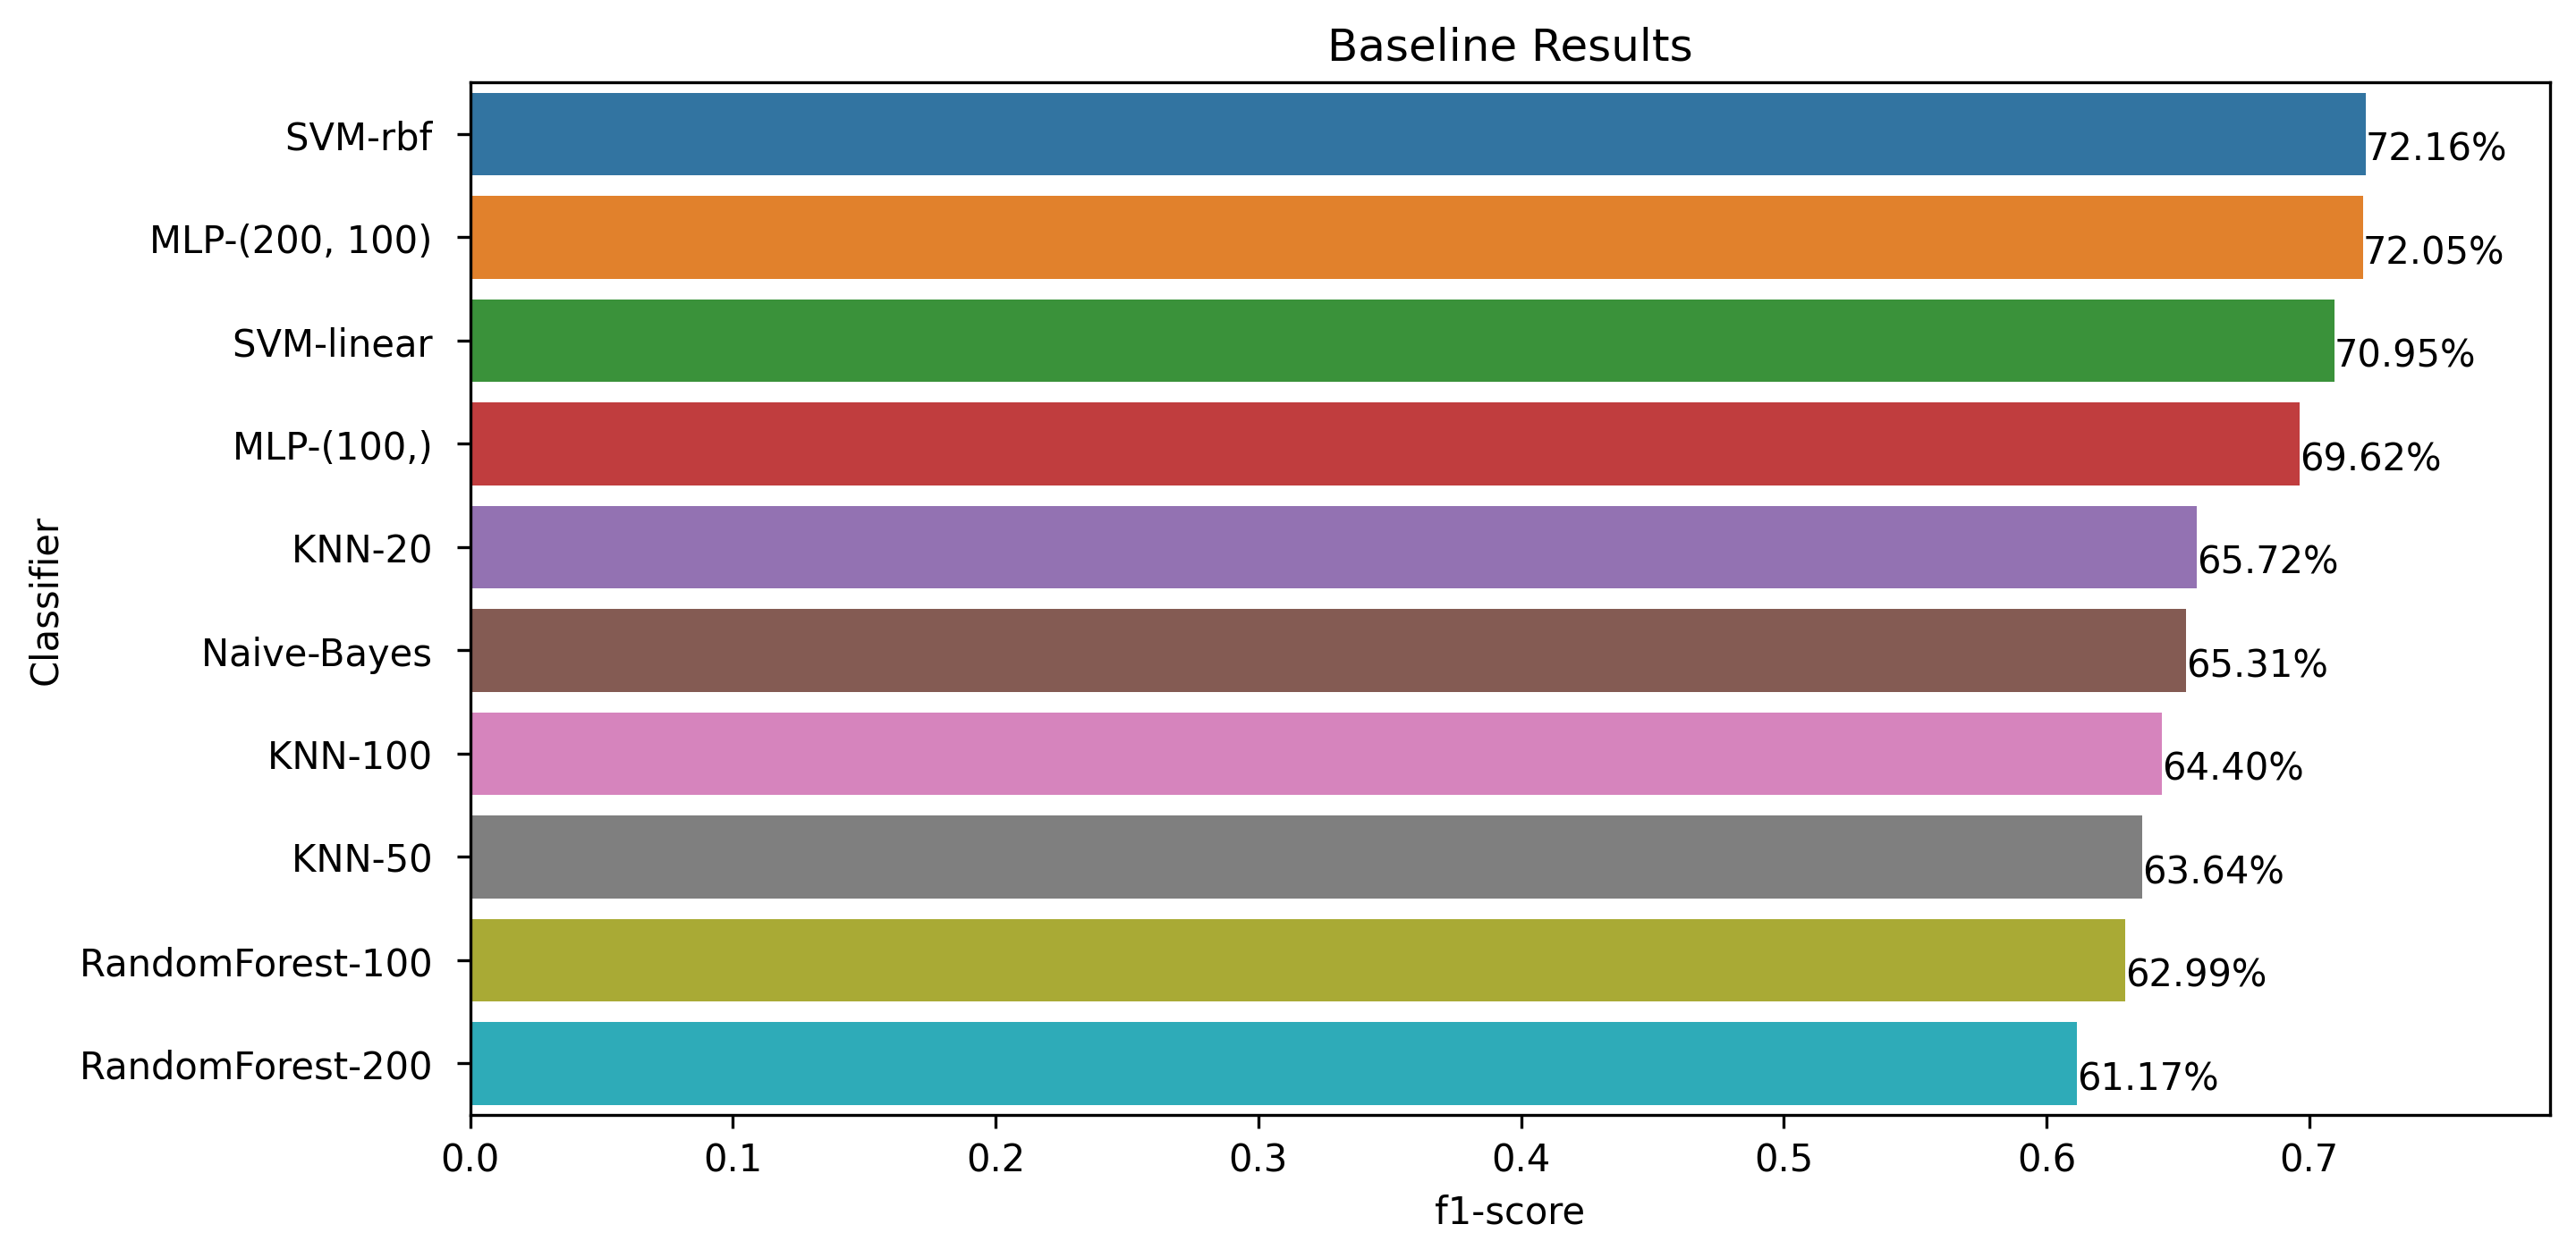

In [51]:
plot_results(baseline_results, 'f1-score')

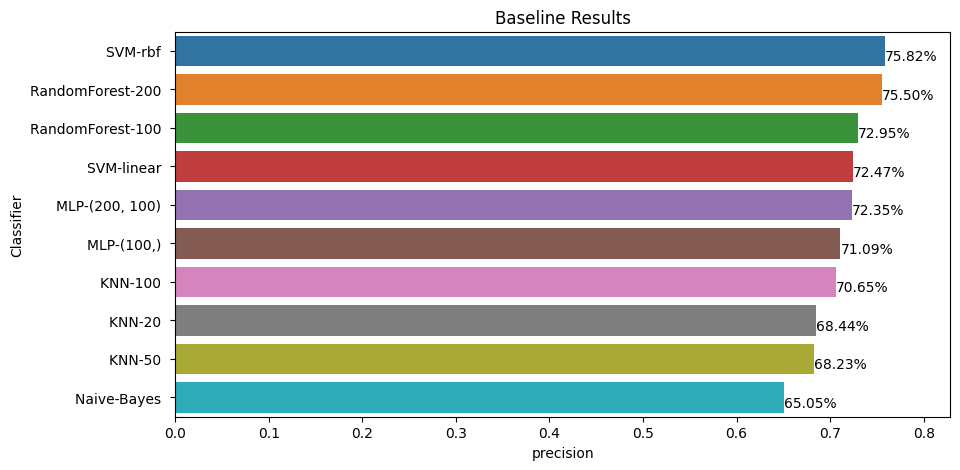

In [32]:
plot_results(baseline_results, 'precision')

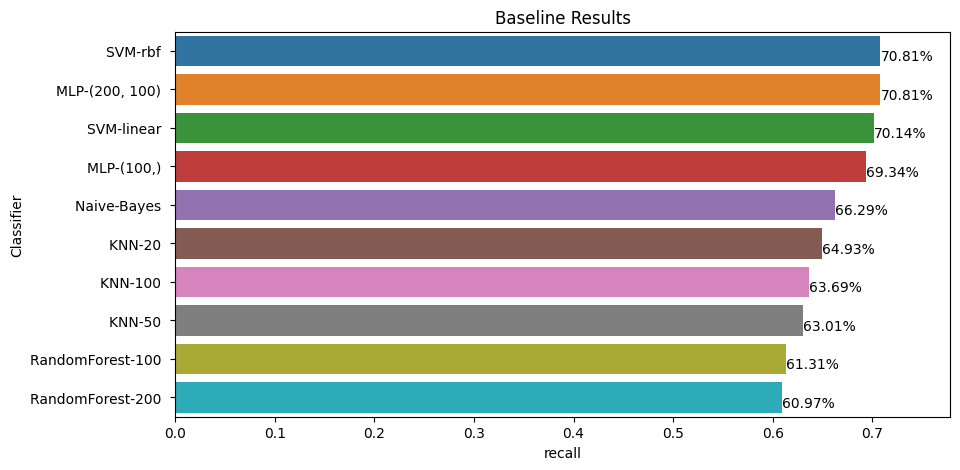

In [33]:
plot_results(baseline_results, 'recall')

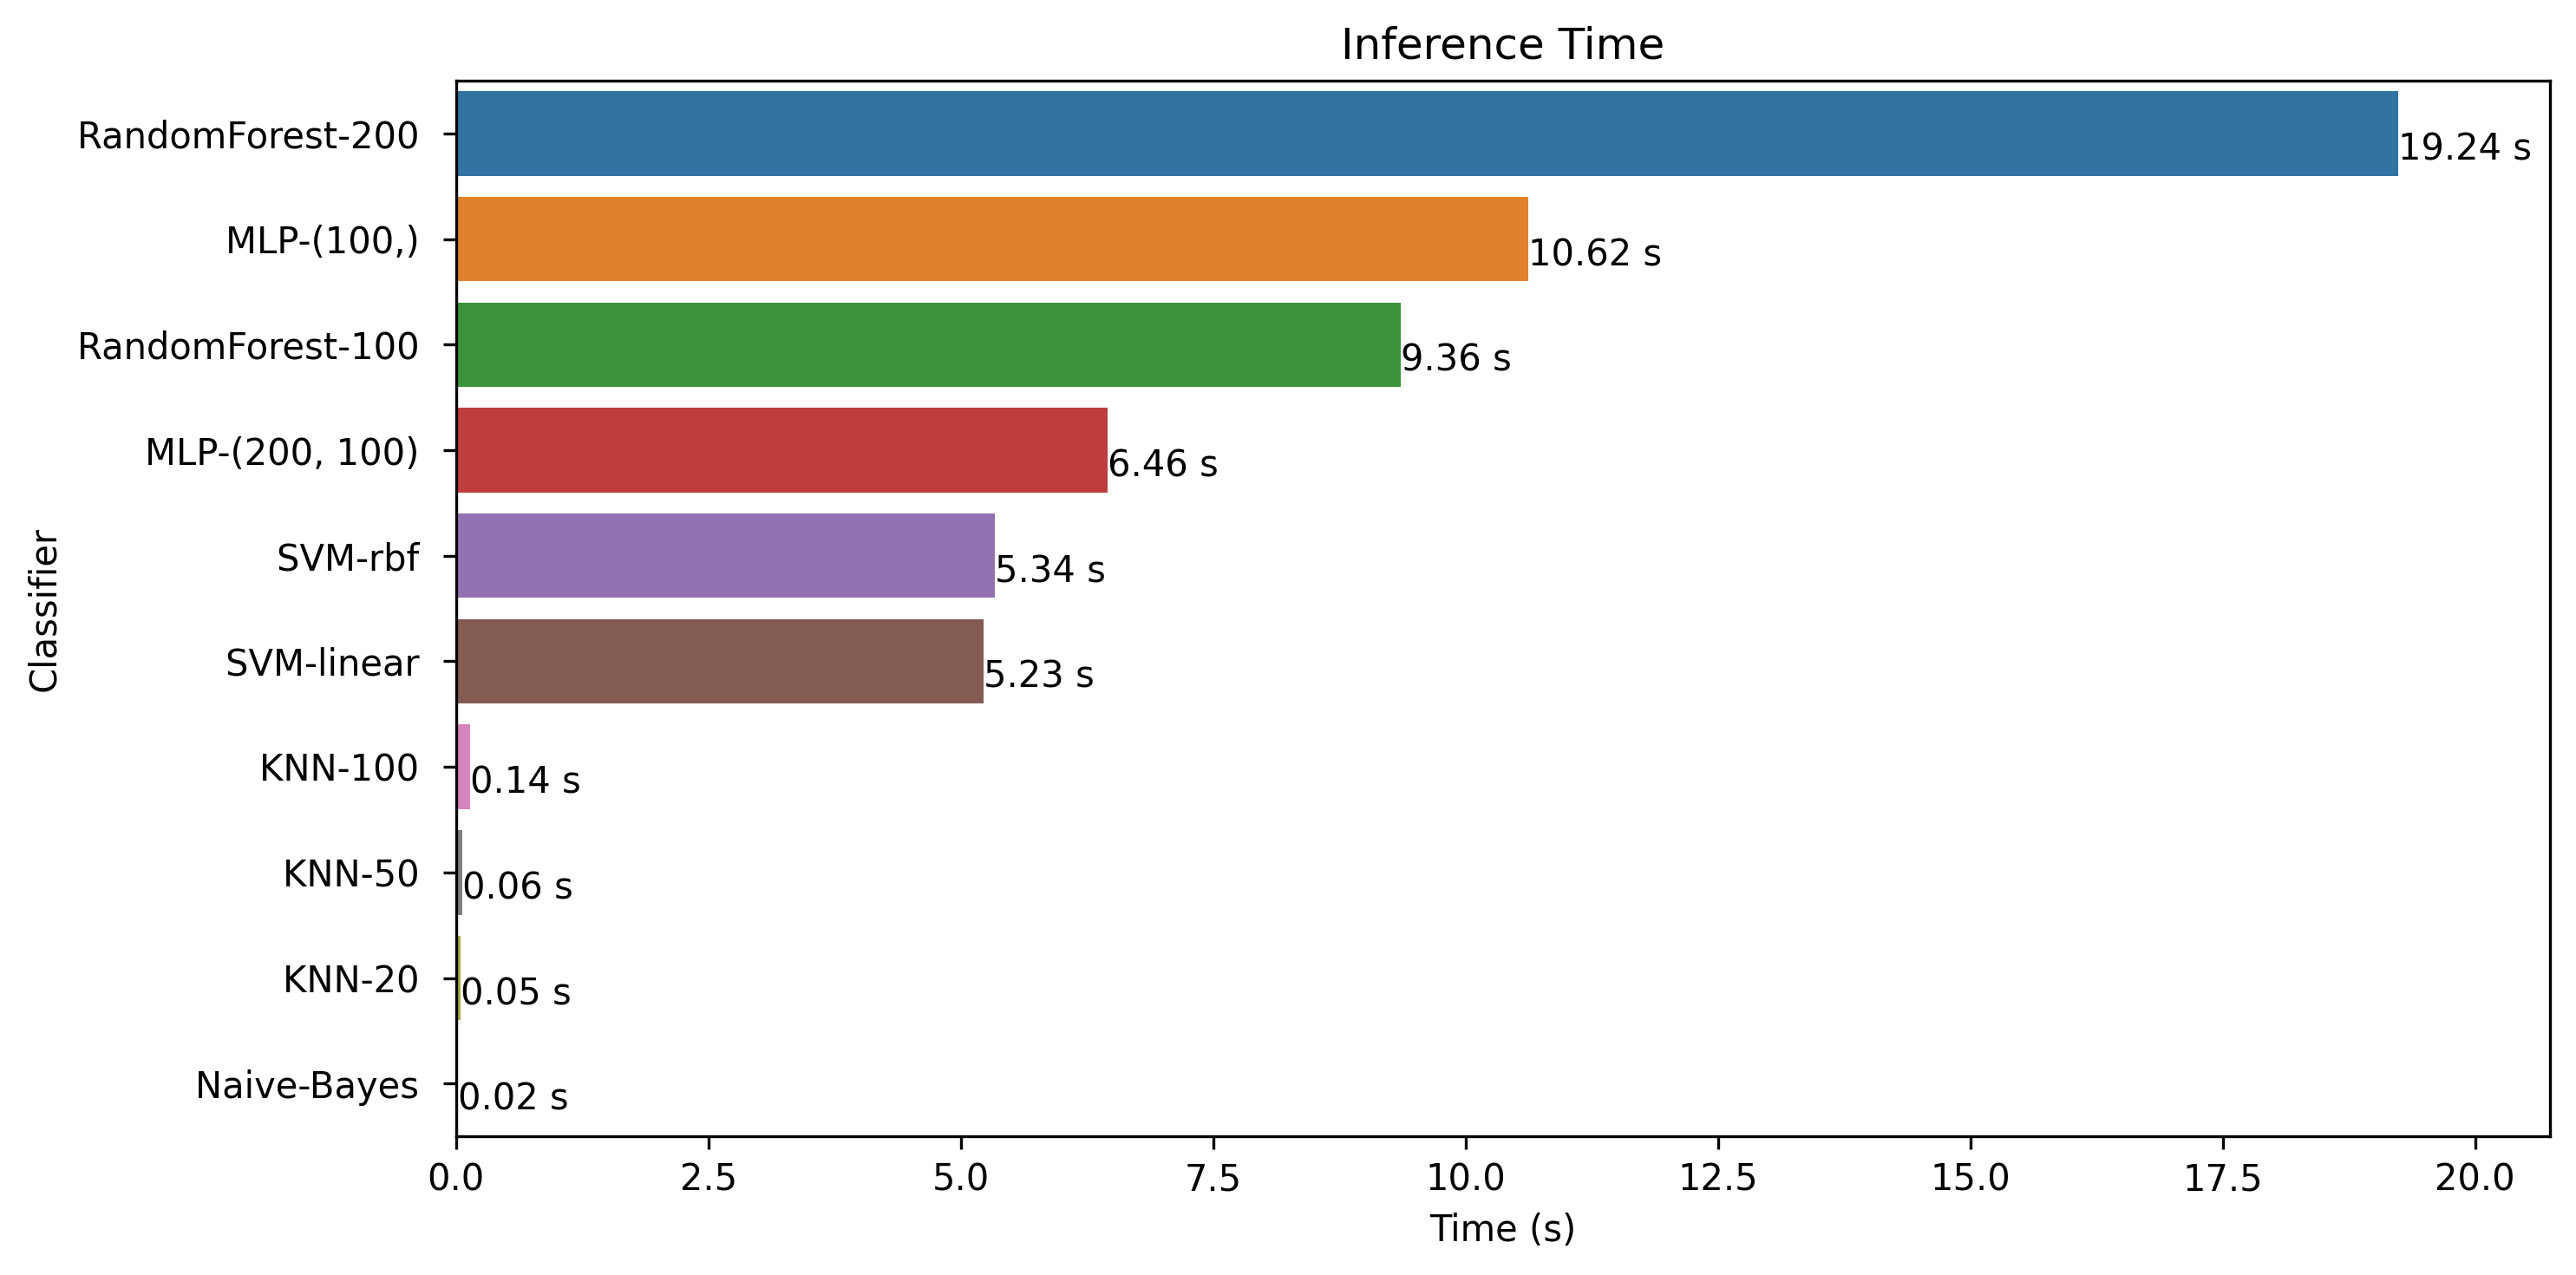

In [83]:
plot_inference_time(baseline_results, 'Inference Time', 'Time (s)')

## Proposed method

In [84]:
sizes = {}

In [85]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

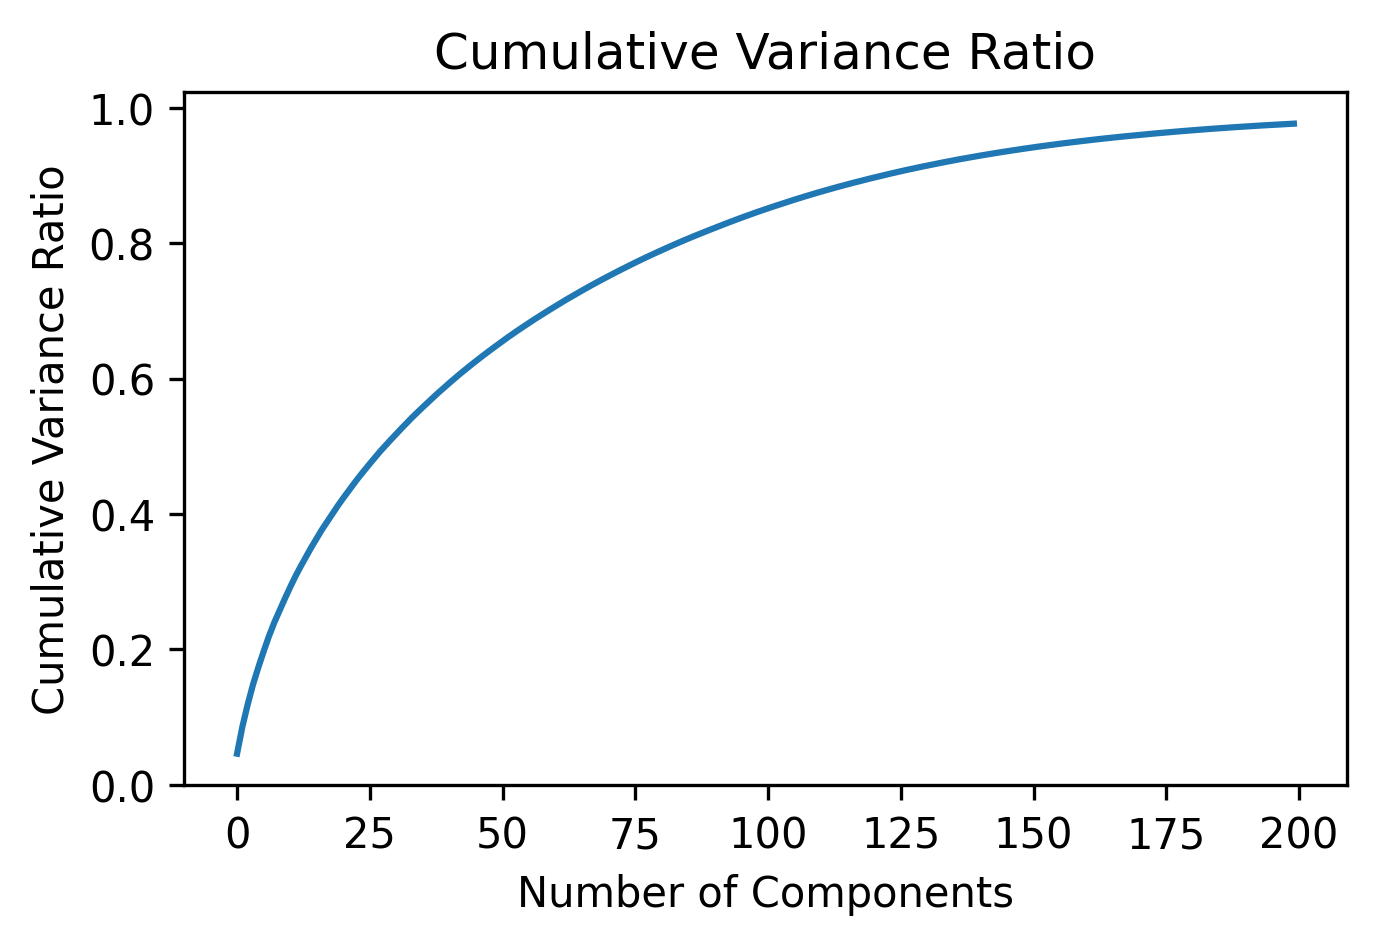

In [22]:
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_dev_pca = pca.transform(X_dev)

plt.rcParams['figure.dpi'] = 300
# plot the cumulative variance ratio
plt.figure(figsize=(5, 3))
plt.title("Cumulative Variance Ratio")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.show()



In [86]:
proposed_results = {}
pca_components = [100]
for n in pca_components:
    pca = PCA(n_components=n, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    sizes[f'PCA-{n}'] = X_train_pca.nbytes
    X_dev_pca = pca.transform(X_dev)
    print(f"PCA with {n} components")
    run_classifiers(X_train_pca, y_train, X_dev_pca, y_dev, results=proposed_results, suffix=f'PCA-{n}')


PCA with 100 components


In [87]:
# plot_results(proposed_results, 'f1-score', figsize=(10, 12))

In [88]:
# plot_results(proposed_results, 'precision', figsize=(10, 12))

In [89]:
# plot_results(proposed_results, 'recall', figsize=(10, 12))

In [90]:
# t-SNE
tsne_components = [50, 100]
for n in tsne_components:
    tsne = TSNE(n_components=n, random_state=2000, method='exact')
    X_train_tsne = tsne.fit_transform(X_train[:1000])
    y_train_tsne = y_train[:1000]
    sizes[f't-SNE-{n}'] = X_train_tsne.nbytes
    X_dev_tsne = tsne.fit_transform(X_dev)
    print(f"t-SNE with {n} components")
    run_classifiers(X_train_tsne, y_train_tsne, X_dev_tsne, y_dev, results=proposed_results, suffix=f't-SNE-{n}')


t-SNE with 50 components


/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

t-SNE with 100 components


/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

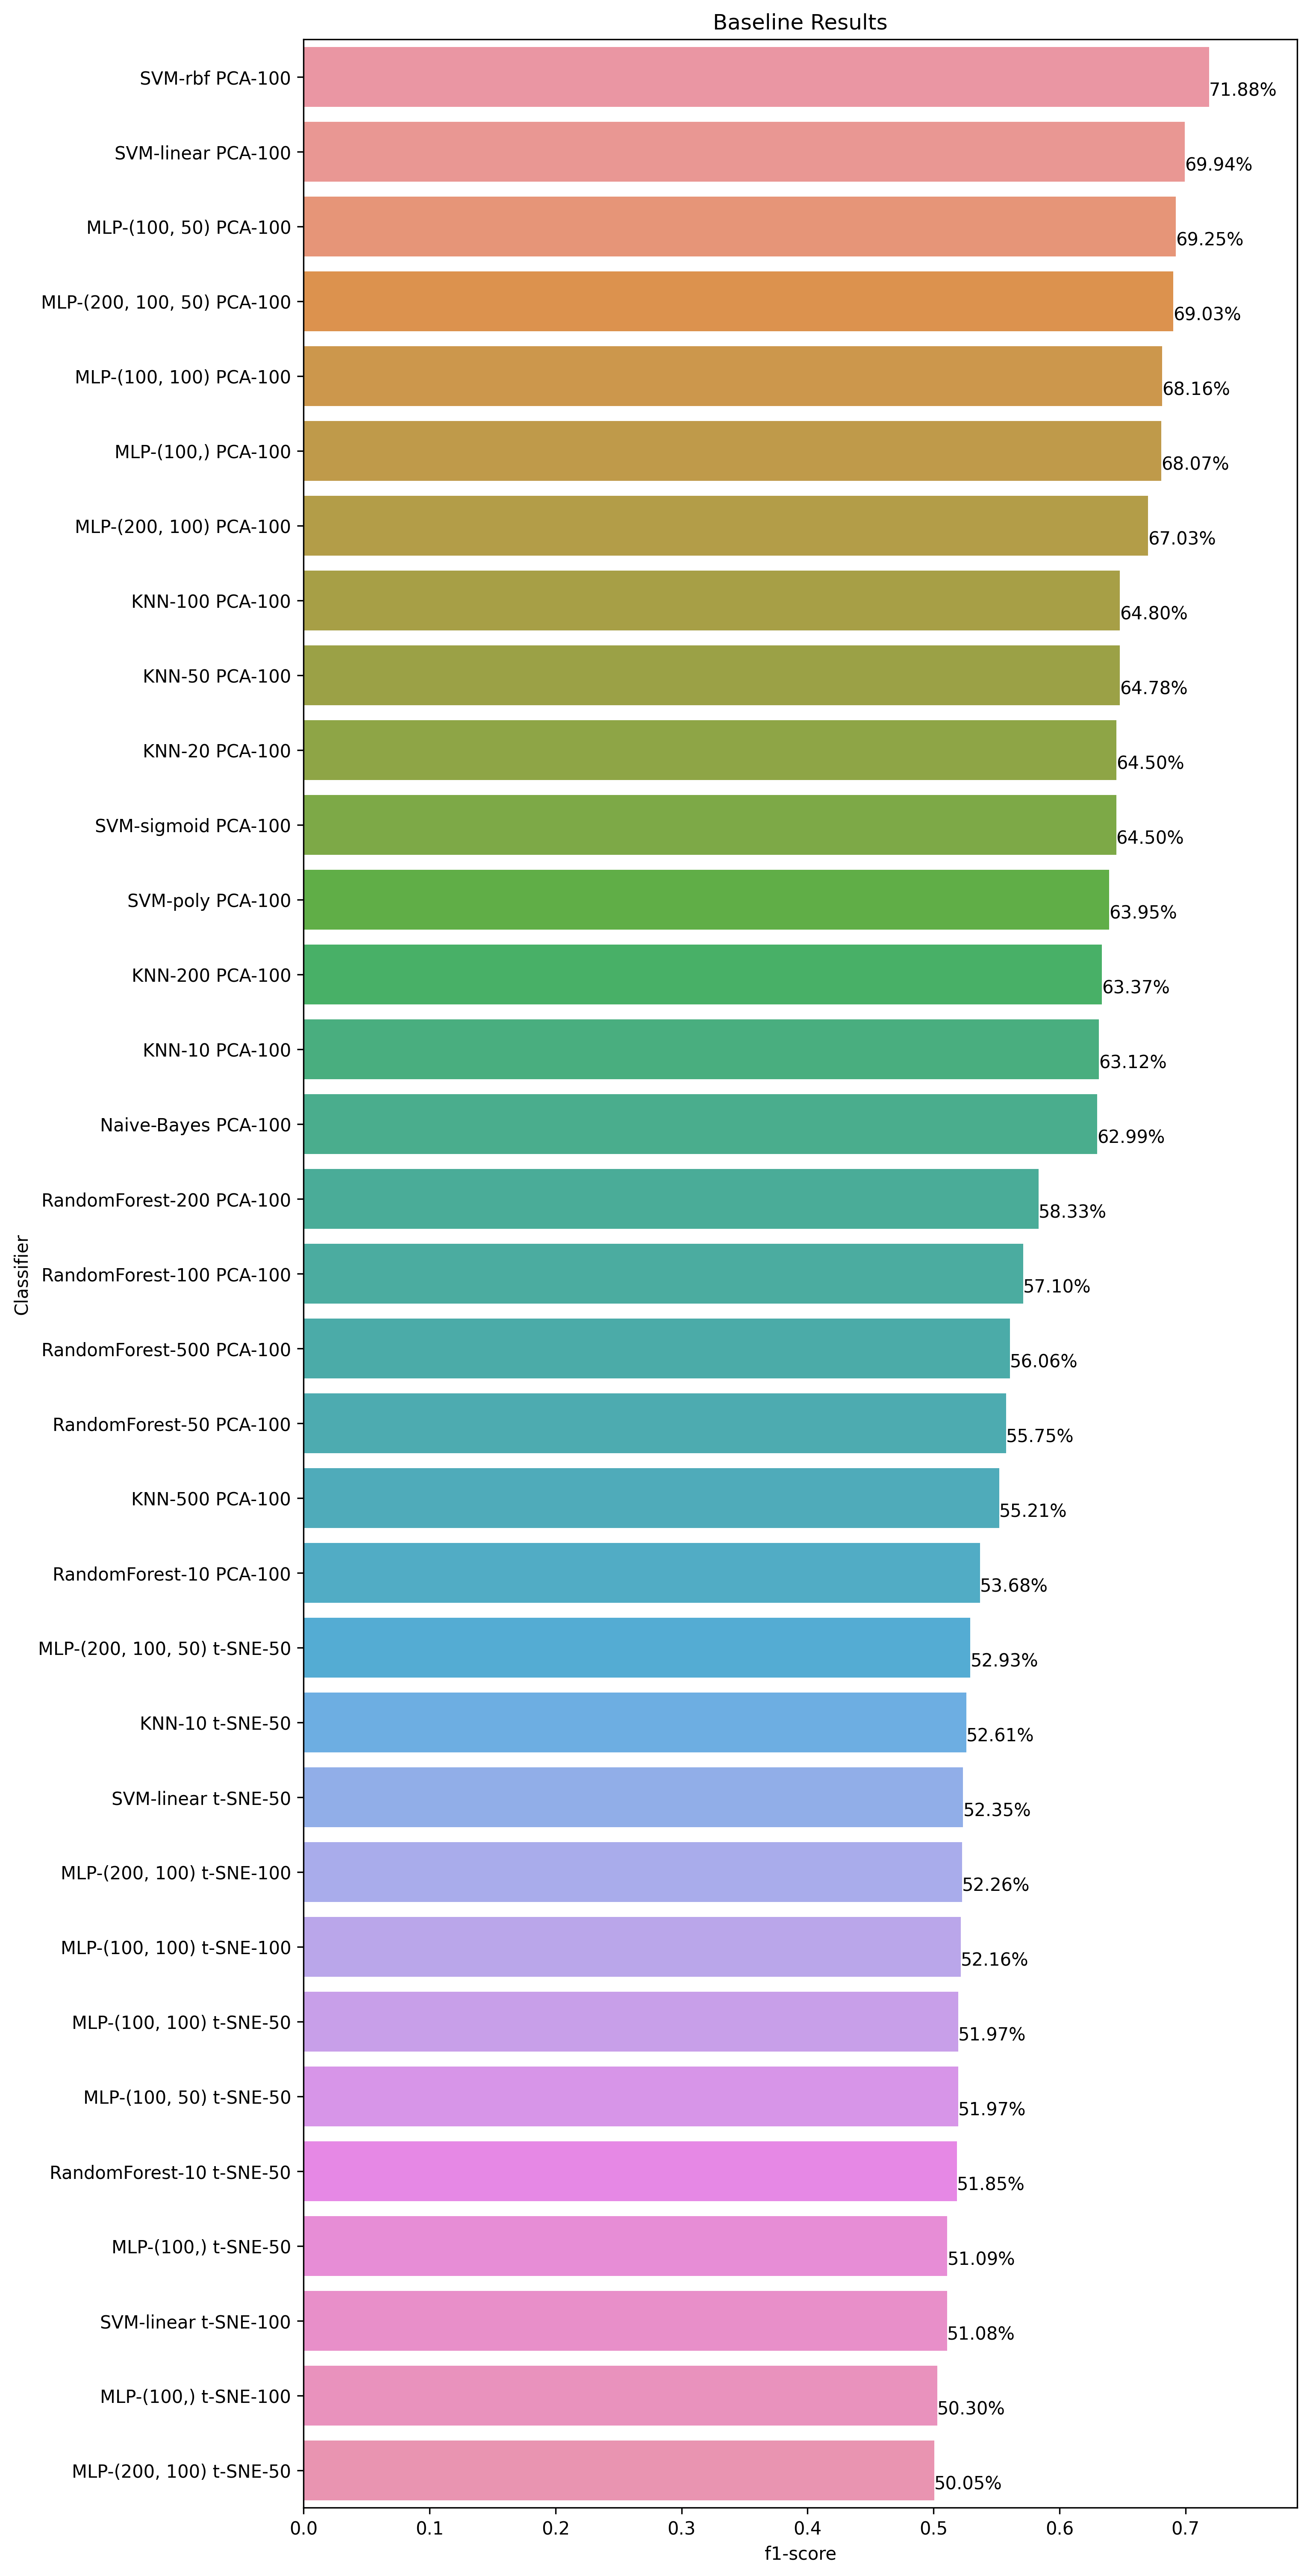

In [91]:
plot_results(proposed_results, 'f1-score', figsize=(10, 25), threshold=0.5)

In [92]:
# plot_results(proposed_results, 'precision', figsize=(10, 25), threshold=0.5)

In [94]:
# plot_results(proposed_results, 'recall', figsize=(10, 25), threshold=0.5)

In [95]:
# use LDA to reduce the dimensionality of the data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
sizes['LDA'] = X_train_lda.nbytes
X_dev_lda = lda.transform(X_dev)

run_classifiers(X_train_lda, y_train, X_dev_lda, y_dev, suffix='LDA', results=proposed_results);

In [97]:
all_results = {**baseline_results, **proposed_results}

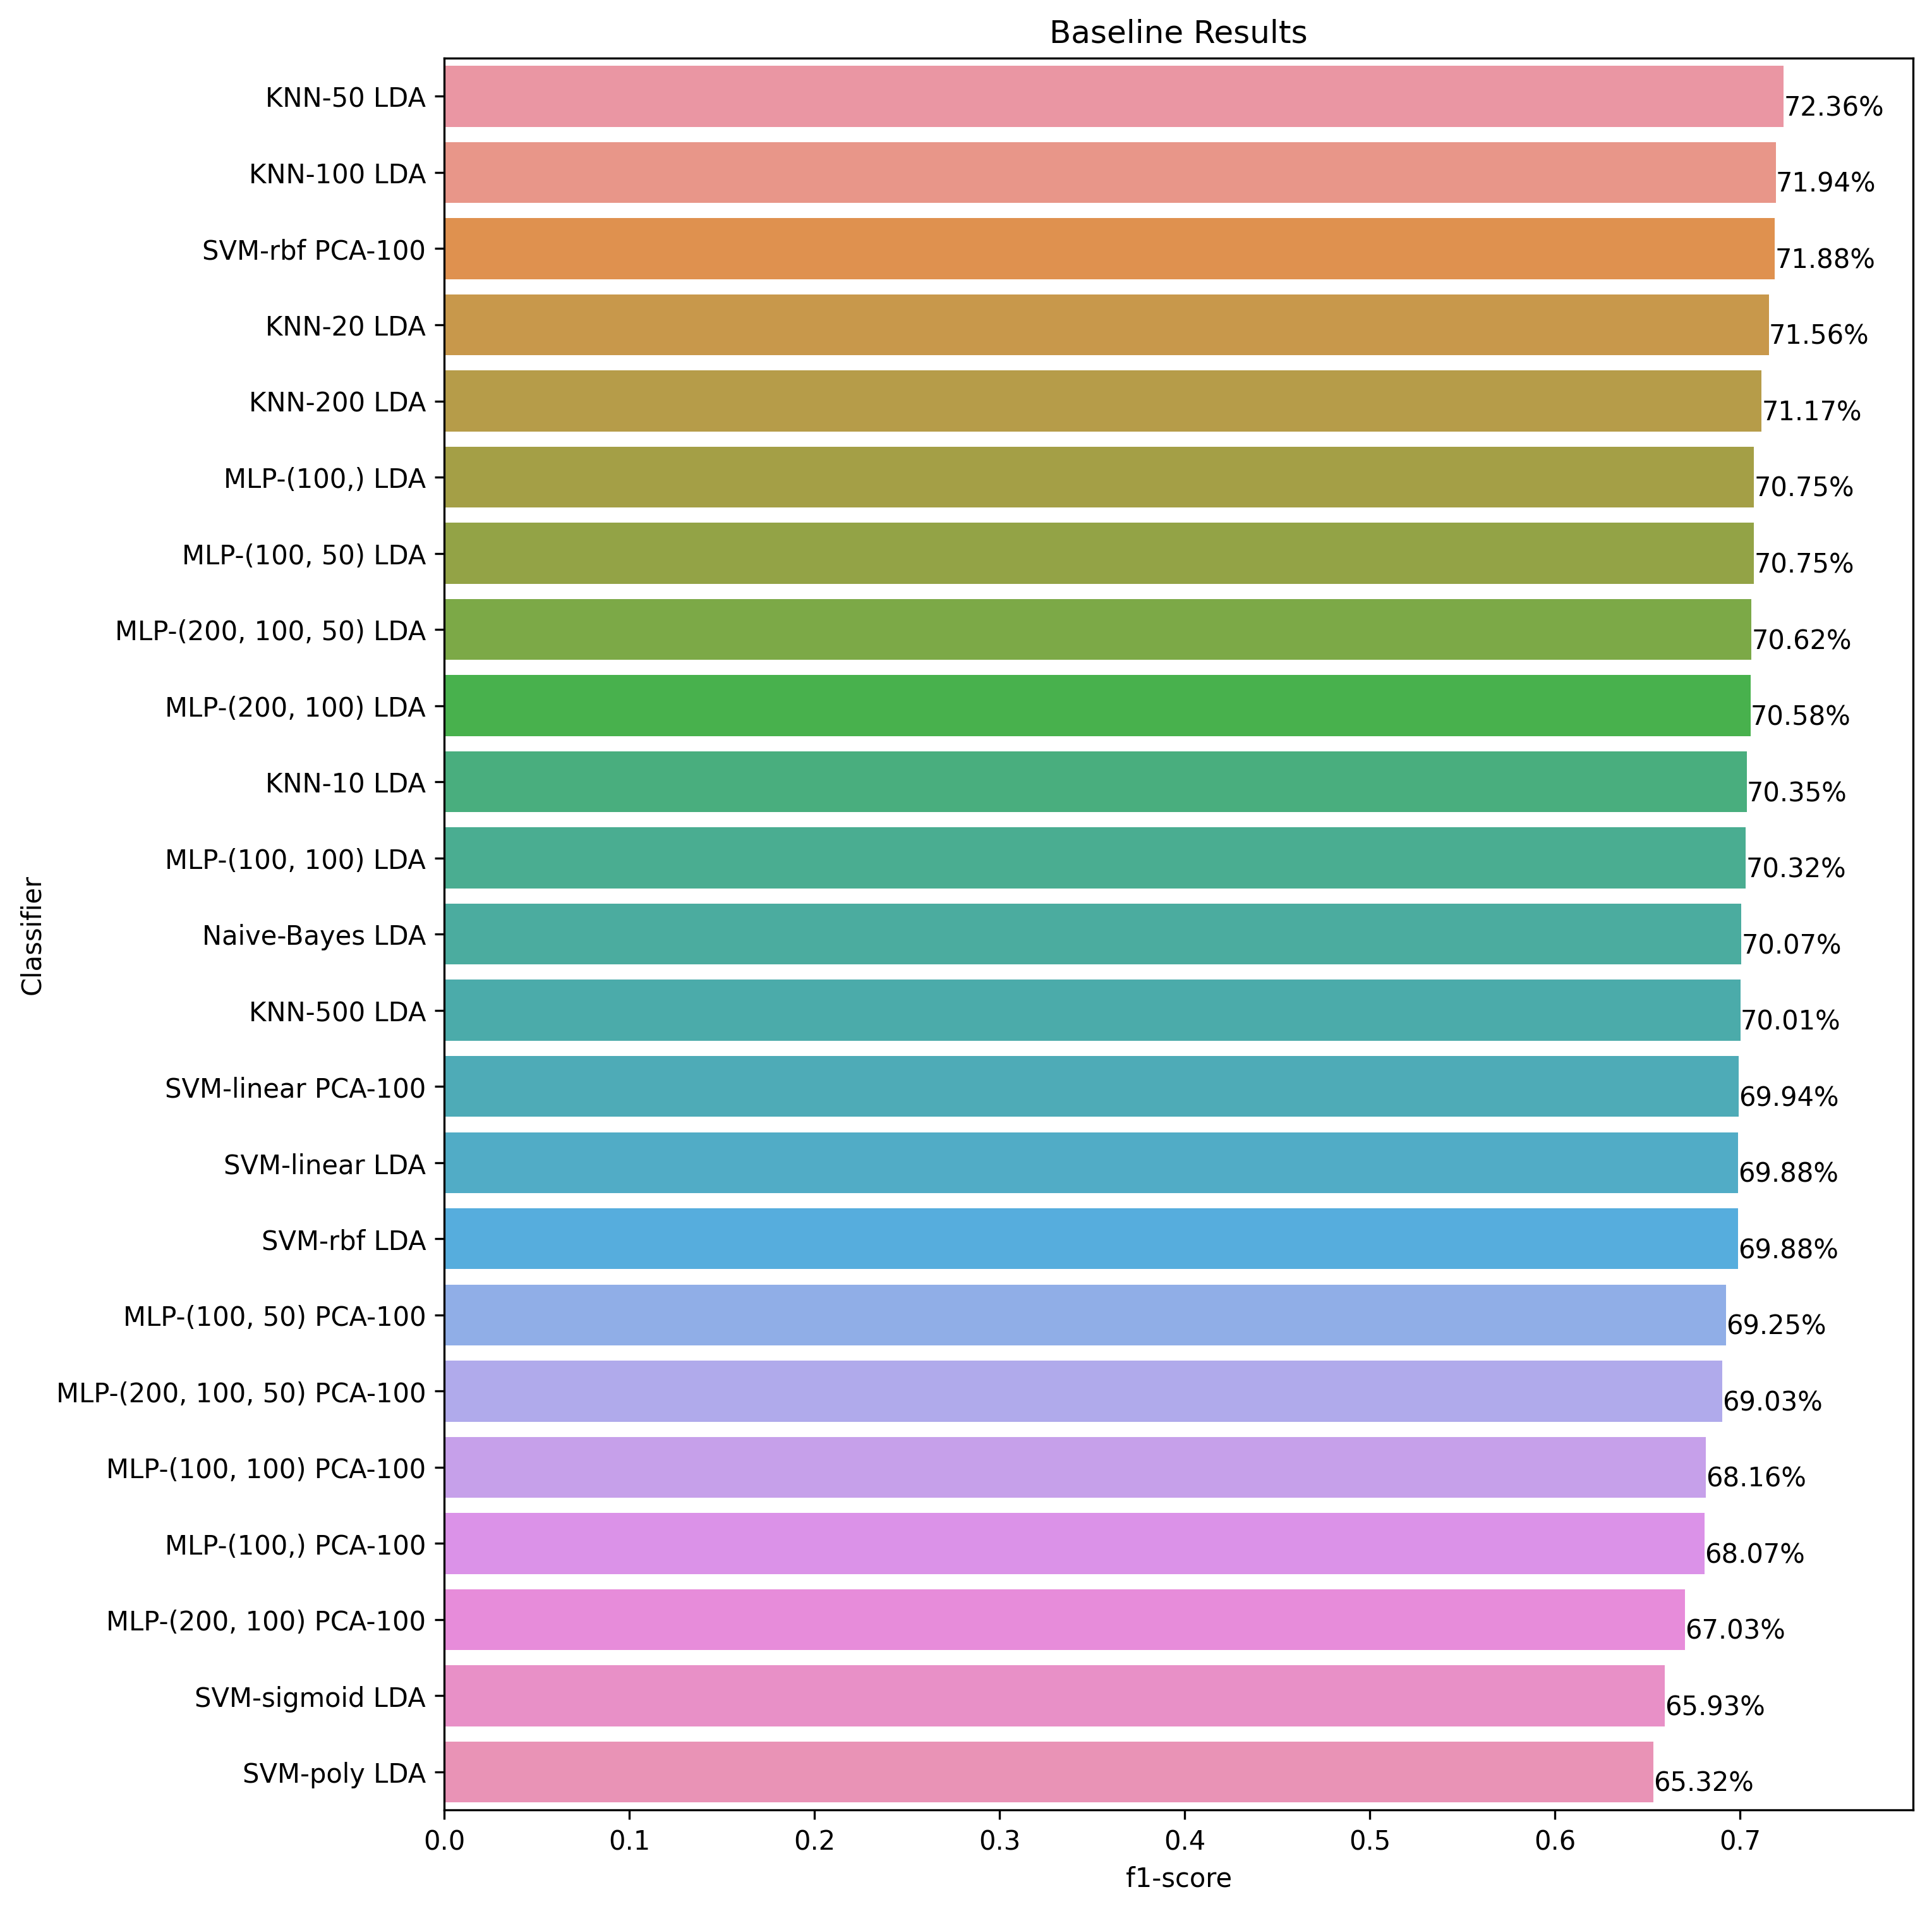

In [96]:
plot_results(proposed_results, 'f1-score', figsize=(10, 12), threshold=0.65)

In [98]:
# plot_results(all_results, 'precision', figsize=(10, 20), threshold=0.65)

In [99]:
# plot_results(all_results, 'recall', figsize=(10, 12), threshold=0.65)

In [102]:
all_results.keys()

dict_keys(['SVM-rbf ', 'SVM-linear ', 'MLP-(100,) ', 'MLP-(200, 100) ', 'RandomForest-100 ', 'RandomForest-200 ', 'KNN-20 ', 'KNN-50 ', 'KNN-100 ', 'Naive-Bayes ', 'SVM-linear PCA-100', 'SVM-poly PCA-100', 'SVM-rbf PCA-100', 'SVM-sigmoid PCA-100', 'MLP-(100,) PCA-100', 'MLP-(100, 100) PCA-100', 'MLP-(200, 100) PCA-100', 'MLP-(100, 50) PCA-100', 'MLP-(200, 100, 50) PCA-100', 'RandomForest-10 PCA-100', 'RandomForest-50 PCA-100', 'RandomForest-100 PCA-100', 'RandomForest-200 PCA-100', 'RandomForest-500 PCA-100', 'KNN-10 PCA-100', 'KNN-20 PCA-100', 'KNN-50 PCA-100', 'KNN-100 PCA-100', 'KNN-200 PCA-100', 'KNN-500 PCA-100', 'Naive-Bayes PCA-100', 'SVM-linear t-SNE-50', 'SVM-poly t-SNE-50', 'SVM-rbf t-SNE-50', 'SVM-sigmoid t-SNE-50', 'MLP-(100,) t-SNE-50', 'MLP-(100, 100) t-SNE-50', 'MLP-(200, 100) t-SNE-50', 'MLP-(100, 50) t-SNE-50', 'MLP-(200, 100, 50) t-SNE-50', 'RandomForest-10 t-SNE-50', 'RandomForest-50 t-SNE-50', 'RandomForest-100 t-SNE-50', 'RandomForest-200 t-SNE-50', 'RandomForest-5

In [105]:
# all_results['SVM-rbf PCA-100']

In [173]:
selected_keys = [
    'SVM-rbf ',
    'SVM-rbf PCA-100',
    'MLP-(200, 100, 50) t-SNE-100',
    'KNN-50 LDA'
]

selected_results = {}
for k in selected_keys:
    if k == 'SVM-rbf ':
        k_n = 'SVM-rbf Original'
        k_n = k_n.replace(' ', '\n')
    elif k == 'MLP-(200, 100, 50) t-SNE-100':
        k_n = 'MLP-\n(200,100,50)\nt-SNE-100'

    else:
        k_n = k.replace(' ', '\n')
    selected_results[k_n] = all_results[k]


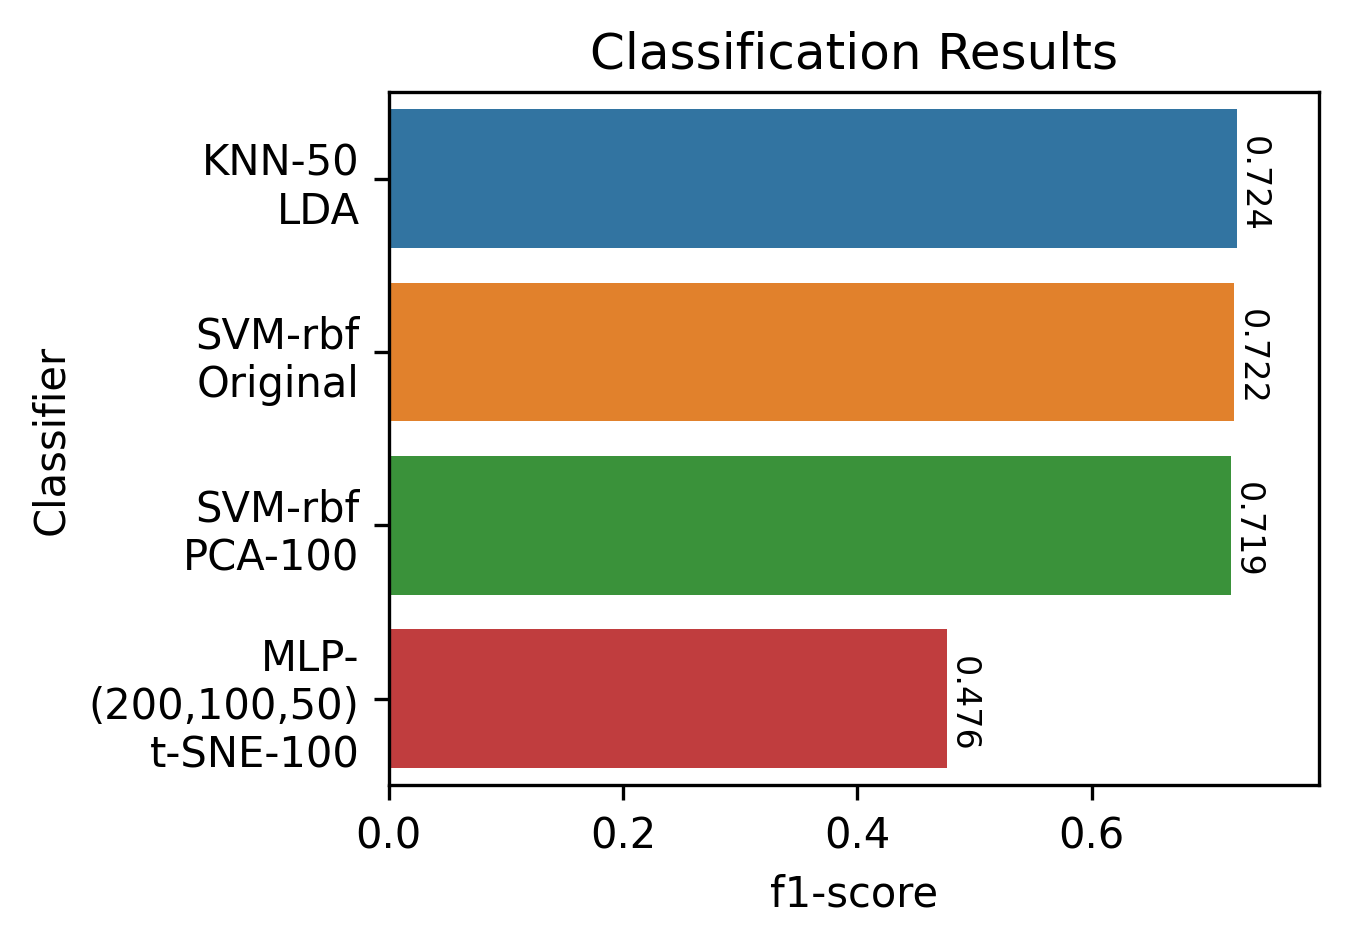

In [195]:
plot_results(selected_results, 'f1-score', figsize=(4, 3), title='Classification Results')

In [117]:
sizes

{'PCA-100': 2386000, 't-SNE-50': 200000, 't-SNE-100': 400000, 'LDA': 47720}

In [210]:
selected_sizes = {}
for k in ['PCA-100', 't-SNE-50', 'LDA', 'original']:
    if k == 'original': 
        selected_sizes['Original'] = sizes[k]
    else:
        selected_sizes[k] = sizes[k]

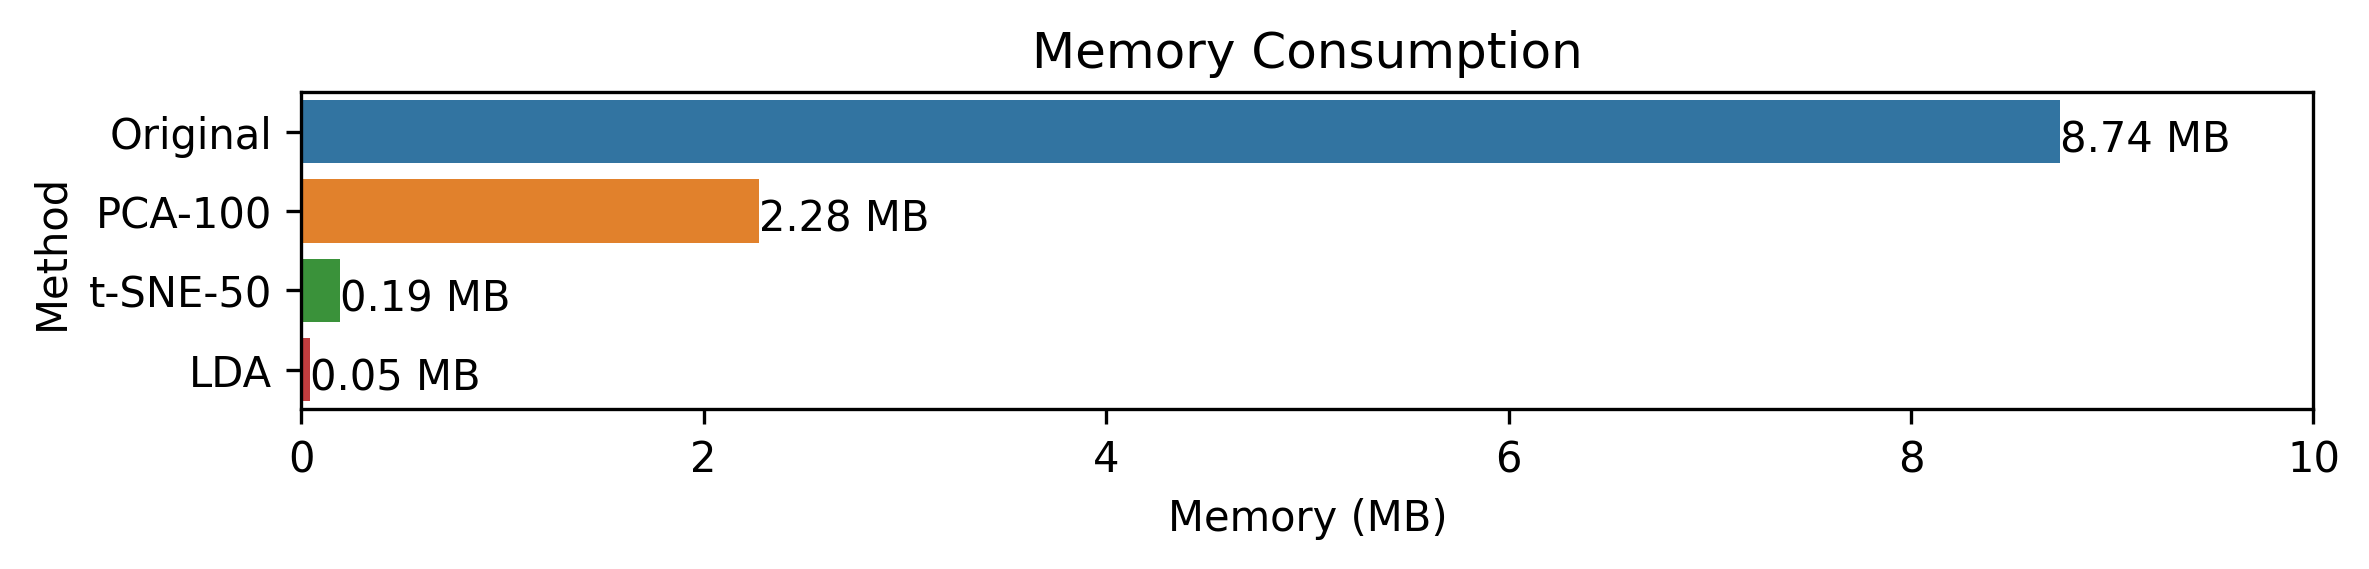

In [211]:
plot_sizes(selected_sizes, 'Memory Consumption', 'Memory (MB)', figsize=(8, 2))

In [114]:
# save all_results, proposed_results, baseline_results
import pickle

with open('all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

with open('proposed_results.pkl', 'wb') as f:
    pickle.dump(proposed_results, f)

with open('baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)


In [123]:
sizes['original'] = (X_train.nbytes)
sizes

{'PCA-100': 2386000,
 't-SNE-50': 200000,
 't-SNE-100': 400000,
 'LDA': 47720,
 'original': 9162240}

In [212]:
compression_ratios = {}
for k, v in selected_sizes.items():
    compression_ratios[k] = sizes['original'] / v

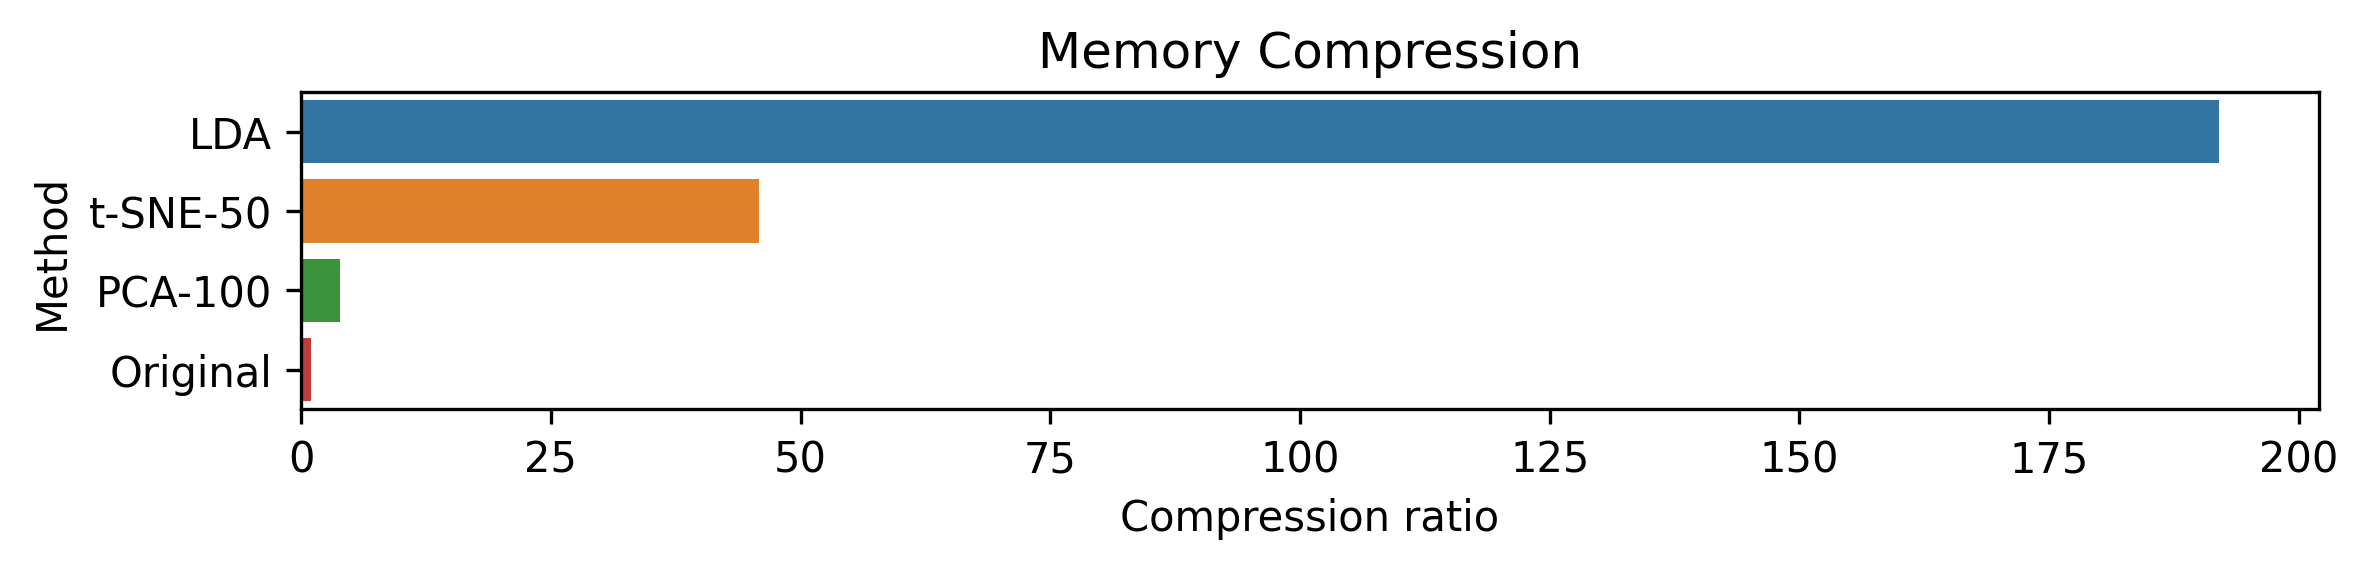

In [214]:
plot_sizes(
    compression_ratios,
    title='Memory Compression',
    xlabel='Compression ratio',
    figsize=(8, 2),
    is_ratio=True
)

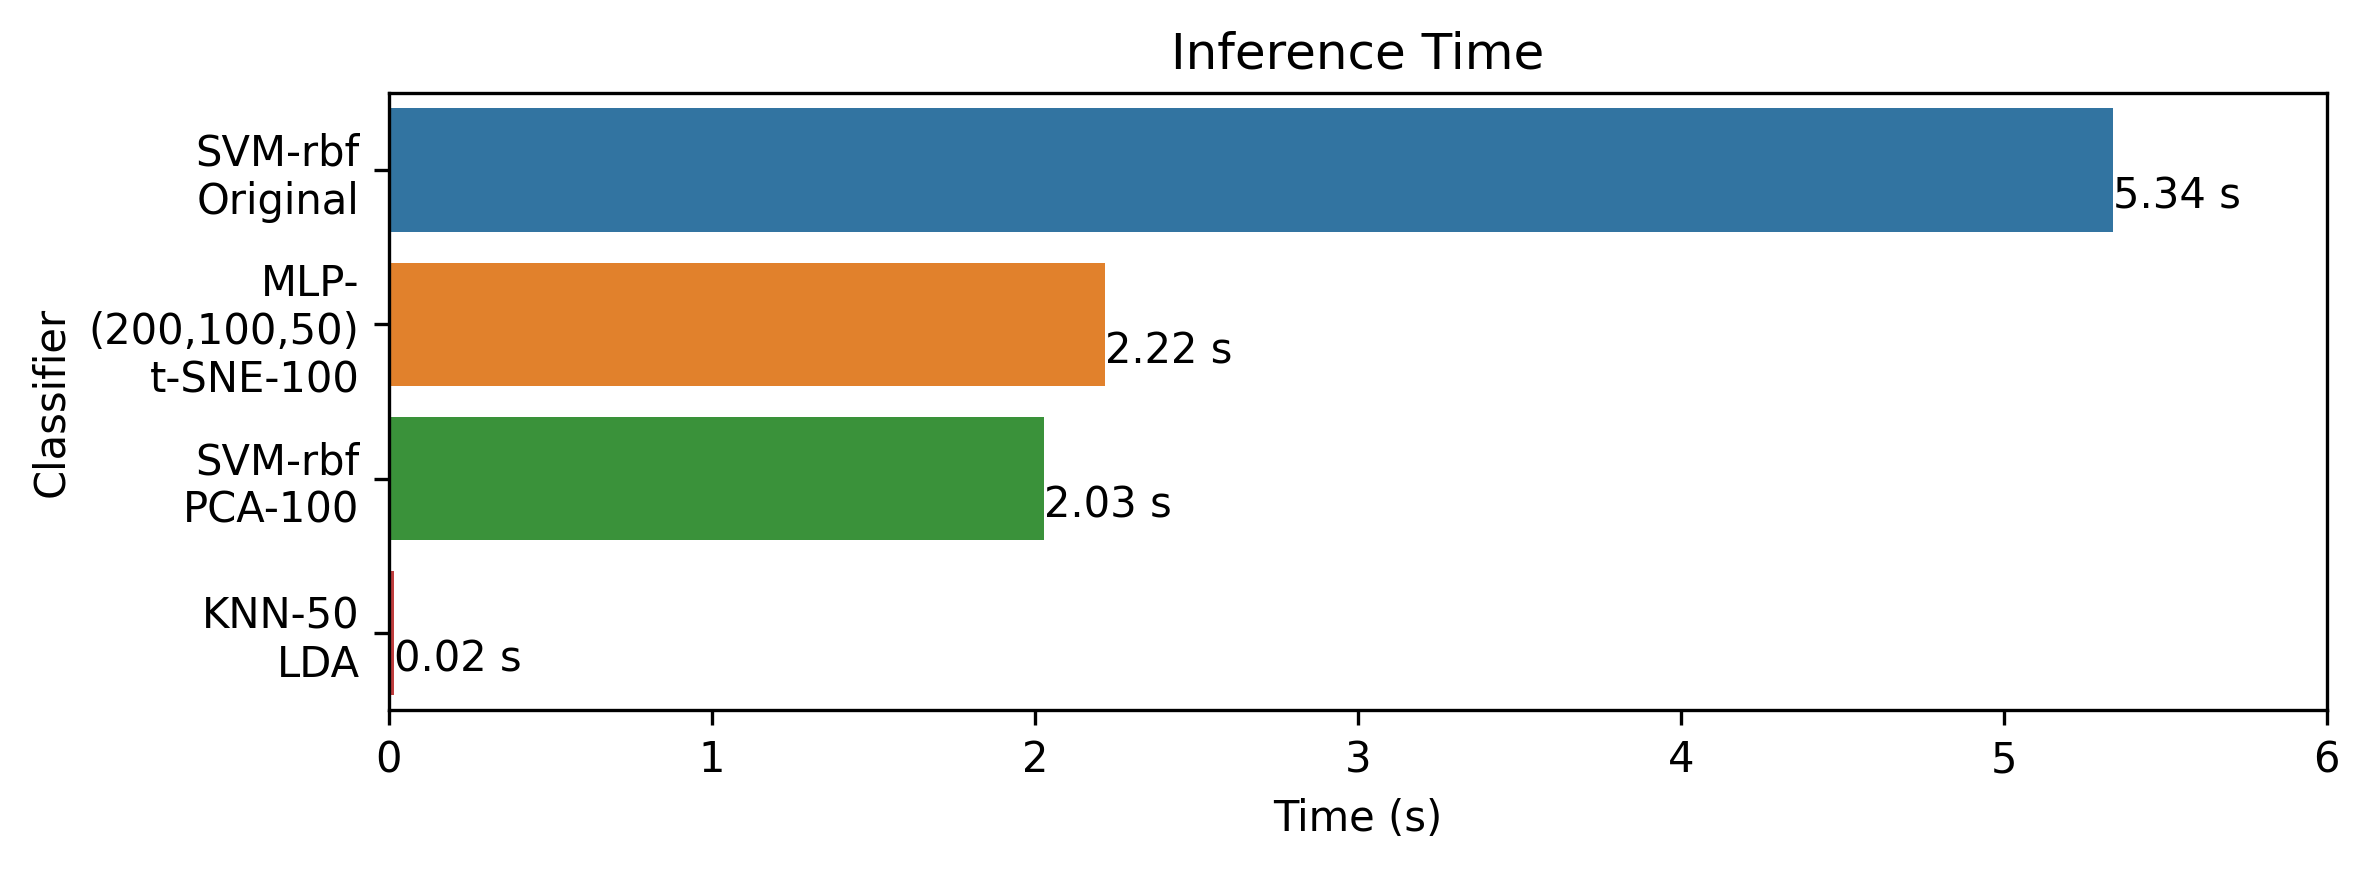

In [221]:
plot_inference_time(selected_results, 'Inference Time', 'Time (s)', figsize=(8, 3))